---
Concept Relevance Propagation (CRP) Global Explanation 
---


**Description:**  
Generates Global reference image for pretrained layer from ImageNet dataset
### Additional Comments
### Author: Viswambhar Yasa

### Date: 09-01-2024

**Contact Information:**  
Email: [yasa.viswambhar@gmail.com](mailto:yasa.viswambhar@gmail.com)

In [1]:
import os
import sys
import torch 
import torch.nn as nn 
from PIL import Image
from pathlib import Path
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision.utils import save_image
from crp.image import imgify,vis_opaque_img,vis_img_heatmap,plot_grid

In [2]:
notebook_directory = Path().resolve().parent
sys.path.insert(0,str(notebook_directory.parent))

from experiment.imagnetdataset import DownloadDataset
from interpret.concept.conceptrelevance import ConceptRelevance

In [3]:
imagenet=DownloadDataset()
load=False
if load:
    imagenet.loadDataSet("Dataset/ImageNetval")

In [4]:
# Define the path to the ImageNet dataset
data_path = "D:/CRP/Dataset/ImageNetval"  # Replace this with the path to your ImageNet dataset

# Define the transformations to be applied to the data
data_transforms = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
])

# Load the ImageNet dataset
dataset = datasets.ImageNet(data_path, split='val', transform=data_transforms)

In [5]:
def get_model(modelname,weight='IMAGENET1K_V1',device="cpu"):
    if modelname=="vgg16":
        pretrained_models = models.vgg16(weights=weight).to(device)
        return pretrained_models
    elif modelname=="resnet18":
        pretrained_models = models.resnet18(weights=weight).to(device)
        return pretrained_models
    else:
        pretrained_models = models.alexnet(weights=weight).to(device)
        return pretrained_models

In [6]:
device="cpu"
modeltype="vgg16"

In [7]:
pretrained_model = get_model(modeltype,device=device)
pretrained_model.eval()

In [ ]:
preprocessing= T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
filesavepath=r"D:/finaldraft/ExplainingWilderness/experiment/Notebooks/referenceimages/VGG16ImageNetConcepts"
build=False
batch_size=16
ckpoint=250

In [ ]:
Concepts=ConceptRelevance(pretrained_model,device=device)
del pretrained_model

In [ ]:
Concepts.build_reference_images(dataset, preprocessing, filesavepath, compositename="epsilonplus", canonizerstype=modeltype, device=device, imagecache=True, imagecachefilepath="cache", max_target="max", build=build, batch_size=batch_size, chkpoint=ckpoint,itstop=5000)

Running Analysis...


  0%|          | 0/625 [00:00<?, ?it/s]

 40%|████      | 250/625 [1:31:59<1:36:35, 15.46s/it]

OSError: 163840 requested and 0 written

In [ ]:
recordlayers=list(Concepts.layer_map.keys())
layer_name=recordlayers[-5]

In [ ]:
recordlayers

In [32]:
channelindex=[0,15,30,45,60,75]
plt_fun=vis_opaque_img

In [33]:
ref=Concepts.layer_reference_image(layer_name, dataset, preprocessing, filesavepath,channelindex, compositename="epsilonplus", canonizerstype=modeltype, device=device, imagecache=False, relevance_range=(0, 8), imagemode="relevance",max_target="max", plotfn=plt_fun, receptivefield=False,build=False, batch=8, chkpoint=50)

100%|██████████| 1/1 [6:22:22<00:00, 22942.23s/it]


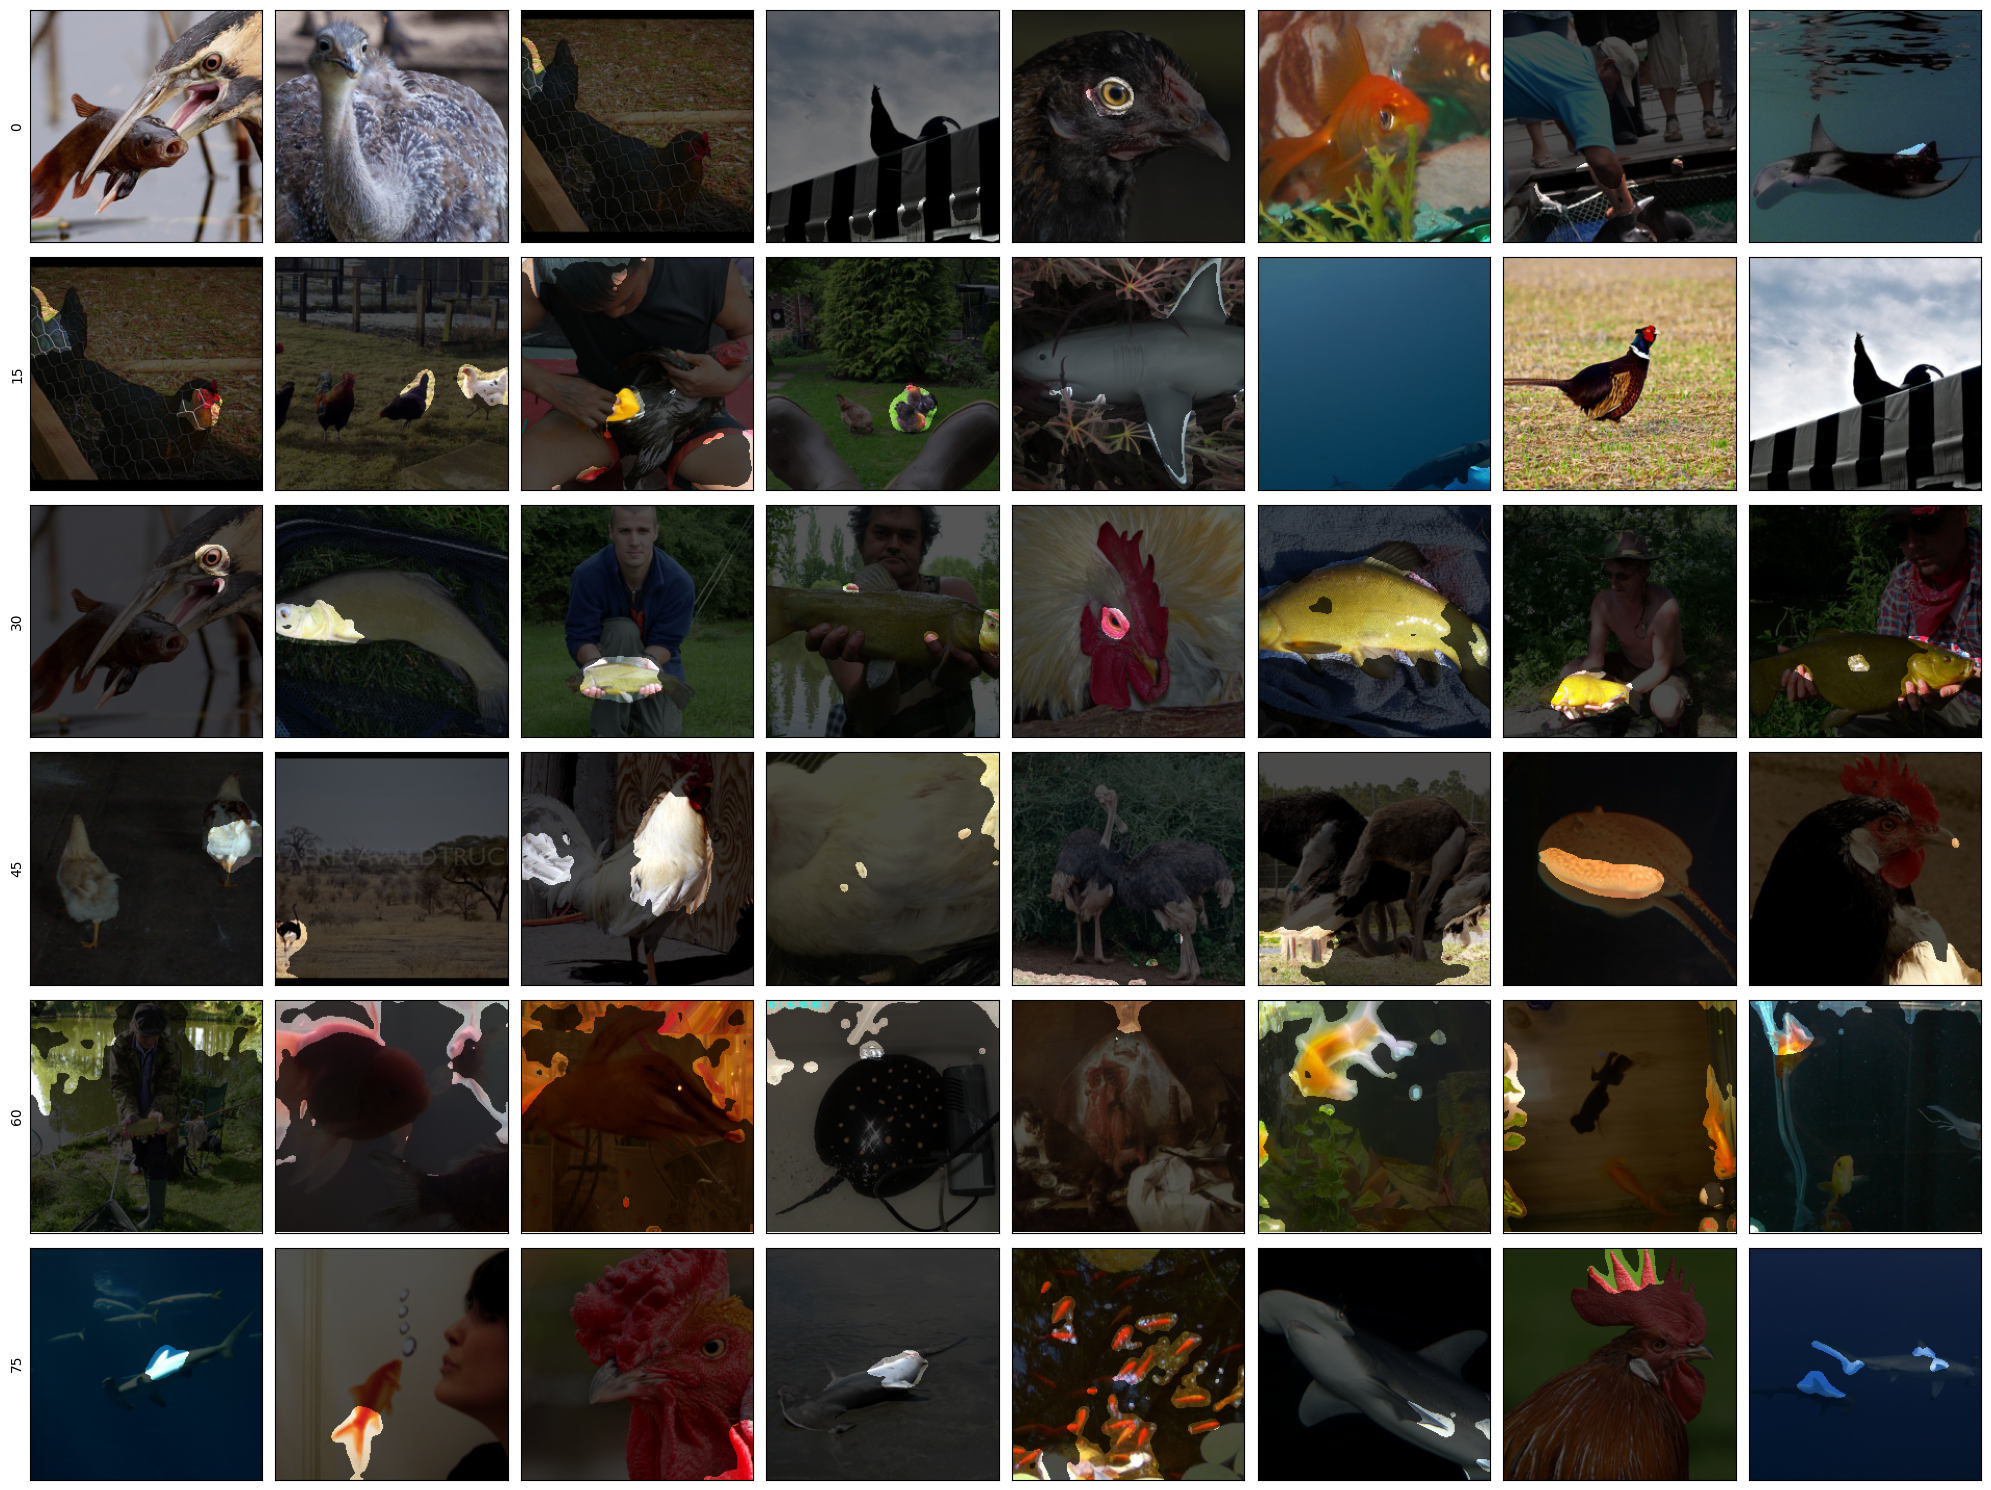

In [34]:
if plt_fun==vis_opaque_img:
    plot_grid(ref,cmap="france",padding=False,figsize=(20,15))

In [36]:
finaldict={}
for channelindex,value in ref.items():
    imagesmaks=vis_opaque_img(value[0],value[1],alpha=0.3,kernel_size=27)[0]
    value[1][value[1]<0]=0
    heatmaps=imgify(value[1],cmap="hot",symmetric=False,level=1,grid=(1,8),padding=False)
    total_width = sum(img.width for img in imagesmaks)
    max_height = max(img.height for img in imagesmaks)

    # Create a new blank image with the calculated dimensions
    combined_image = Image.new('RGB', (total_width, max_height))

    # Paste each image into the combined image
    x_offset = 0
    for img in imagesmaks:
        combined_image.paste(img, (x_offset, 0))
        x_offset += img.width
    width1, height1 = heatmaps.size
    width2, height2 = combined_image.size

    # Ensure both images have the same height
    if width1 != width2:
        raise ValueError("Image heights must be the same")

    # Calculate the total width for the concatenated image
    total_width = width1 
    max_height = height1 + height2# Since the heights are the same

    # Create a new blank image with the calculated dimensions
    final_image = Image.new('RGB', (total_width, max_height))

    # Paste the first image at the left
    final_image.paste(heatmaps, (0, 0))

    # Paste the second image to the right of the first image
    final_image.paste(combined_image, (0,height1 ))
    finaldict[channelindex]=final_image

TypeError: object of type 'Image' has no len()

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(len(finaldict.keys()),1, figsize=(25, 15))  # Adjust the figsize as needed

# Loop through the images and labels, and plot them as rows
for i,(keys,image) in enumerate(finaldict.items()):
    axs[i].imshow(image)
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(True)
    axs[i].set_ylabel("ch:"+str(keys), fontsize=18, rotation='vertical')
    #axs[i].get_yaxis().set_visible(True)
    axs[i].set_yticklabels([])
    #axs[i].axis('off')

# Adjust spacing between subplots
plt.tight_layout()
saved_path="D:/finaldraft/ExplainingWilderness/experiment/Notebooks/temp/concepts"
plt.savefig(os.path.join(saved_path,"./"+modeltype+"_"+layer_name+"_pretrained_global_concepts_heatmaps_masks.png"),dpi=600)
# Show the plot
plt.show()